# Machine Learning Models on the IDS 2017

In this notebook, decision tree and random forest based machine learning algorithms are applied to the ids2017 dataset. Several methods for resolving the class imbalance are tested. Decision tree algorithms were chosen for their effectiveness and the training time which were better than other machine learning models. RT and RF based algorithms performed better in the preliminary experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"..\CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

#### Check for invalid values

In [3]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Identify columns with NaN, infinity, or negative values
nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]

print("Columns with NaN values:", nan_columns.tolist())
print("Columns with infinite values:", inf_columns.tolist())

# Calculate the percentage of NaN, infinite, and negative values
nan_percentage = df[nan_columns].isna().mean() * 100
inf_percentage = df[inf_columns].map(lambda x: np.isinf(x)).mean() * 100

print("Percentage of NaN values in each column:\n", nan_percentage)
print("Percentage of infinite values in each column:\n", inf_percentage)

Columns with NaN values: ['flow_bytes_s']
Columns with infinite values: ['flow_bytes_s', 'flow_packets_s']
Percentage of NaN values in each column:
 flow_bytes_s    0.047973
dtype: float64
Percentage of infinite values in each column:
 flow_bytes_s      0.053308
flow_packets_s    0.101281
dtype: float64


Given the low percentage of null values in only one column (0.04%), it is safe to drop the rows with NaN values. The same applies to th infinite values. 

In [4]:
def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinite, or negative values
    nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
    inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]

    # Drop rows with NaN values (low percentage of NaN values)
    df = df.dropna(subset=nan_columns)

    # Drop rows with infinite values (assuming low percentage)
    for col in inf_columns:
        df = df[np.isfinite(df[col])]
    
    return df

In [5]:
df = replace_invalid(df)

In [6]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## 2. Feature Selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [7]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [8]:
X = X.drop(columns=features_no_var_numeric)
X = X.drop(columns=['destination_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 70 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  flow_

### Remove collinear variables

In [9]:
def correlation_feature_selection(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = correlation_feature_selection(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 39 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_min                 float64
 14  fwd_iat_min                  float64
 15  bwd_iat_total                float64
 16  bwd_iat_mean                 float64
 17  bwd_iat_std                  float64
 18  bwd_iat_max                  float64
 19  fwd_p

### Information gain selection

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

def oversample_minority_classes(X, Y, sample_size=1000):
    y = Y["label_code"]
    # Create a subset of the oversampled data
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_sample, y_sample)
    return X_resampled, y_resampled

def information_gain_feature_selection(X, Y, sample_size=1000):
    # Create an oversampled subset of the data
    X_sample, y_sample = oversample_minority_classes(X, Y, sample_size)
    # Create is_attack column based on label_code
    y_sample = (y_sample != 0).astype(int)
    # Perform feature selection on the oversampled subset
    info_gain = mutual_info_classif(X_sample, y_sample)
    info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
    info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
    print(info_gain_df)
    selected_features = info_gain_df[info_gain_df['Information Gain'] > 0.1]['Feature'].tolist()
    return selected_features

# Determine the selected features using the oversampled subset
selected_features = information_gain_feature_selection(X, Y)

# Apply the selected features to the main dataset
X = X[selected_features]

# Display information about the selected features
X.info()

                        Feature  Information Gain
1                 flow_duration          0.226799
10               flow_packets_s          0.217075
3   total_length_of_fwd_packets          0.208628
11                flow_iat_mean          0.208022
9                  flow_bytes_s          0.203155
23                bwd_packets_s          0.198369
31       init_win_bytes_forward          0.188865
4         fwd_packet_length_max          0.187053
6        fwd_packet_length_mean          0.181985
12                 flow_iat_std          0.175442
7         bwd_packet_length_max          0.164733
32      init_win_bytes_backward          0.155849
18                  bwd_iat_max          0.149083
15                bwd_iat_total          0.147353
21            fwd_header_length          0.143969
16                 bwd_iat_mean          0.141956
5         fwd_packet_length_min          0.112573
24            min_packet_length          0.110562
8         bwd_packet_length_min          0.106420


## 3. Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [12]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [13]:
Y_test.label.value_counts()

label
BENIGN                        454265
DoS Hulk                       46025
PortScan                       31761
DDoS                           25605
DoS GoldenEye                   2059
FTP-Patator                     1587
SSH-Patator                     1180
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         301
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         2
Name: count, dtype: int64

Statistics for the training set

In [14]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8032
is_attack
0    1817055
1     445245
Name: count, dtype: int64


## 4. Machine Learning Classifiers with Default Hyperparameters

### Helper functions

In [15]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

In [16]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average='weighted')
    auc = roc_auc_score(y_true, y_predict)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

def calculate_metrics_by_label(y_true, y_pred, labels):
    results = []
    unique_labels = labels.unique()
    for label in unique_labels:
        indices = labels == label
        accuracy = accuracy_score(y_true[indices], y_pred[indices])
        results.append({
            'Label': label,
            'Accuracy': accuracy,
        })
    return pd.DataFrame(results)

In [17]:
def test_metrics(model_name, model, dataset_type, scaler):
    # Predict and evaluate on the test set
    print(f"{model_name} with {dataset_type} Test Set Performance")
    Y_pred = model.predict(scaler.transform(X_test))
    metrics = metrics_report(f"Test {model_name} ({dataset_type})", Y_test.is_attack, Y_pred)
    plot_confusion_matrix(f"{model_name} ({dataset_type})", Y_test, Y_pred)
    # Calculate metrics by label
    metrics_by_label = calculate_metrics_by_label(Y_test.is_attack, Y_pred, Y_test.label)
    metrics_by_label['Method'] = dataset_type
    print(f"Metrics by Label ({dataset_type}):")
    print(metrics_by_label)
    return metrics, metrics_by_label

In [18]:
def plot_overall_accuracy(metrics):
    methods = ['original', 'random', 'smote', 'adasyn']
    overall_accuracies = []

    # Extract overall accuracy for each method
    for method in methods:
        overall_accuracies.append(metrics[method][0]['accuracy'])

    # Plotting the overall accuracies
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, overall_accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Overall Accuracy by Method')
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1)
    plt.grid(True)

    # Display the values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.5f}', ha='center', va='bottom')

    plt.show()

### Resampling methods

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def resample_dataset(X, Y, min_samples, attack_labels, technique='smote'):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values

    if technique == 'random':
        resampler = RandomOverSampler(random_state=42, sampling_strategy=samples_number)
    elif technique == 'smote':
        resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    elif technique == 'adasyn':
        resampler = ADASYN(random_state=42, sampling_strategy=samples_number)
    else:
        raise ValueError("Invalid resampling technique. Choose 'random', 'smote', or 'adasyn'.")

    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

In [20]:
X_random_train, Y_random_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "random")
X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "smote")
X_adasyn_train, Y_adasyn_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "adasyn")

In [21]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [22]:
Y_random_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [23]:
Y_smote_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [24]:
Y_adasyn_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS Slowhttptest               100149
DoS slowloris                  100079
Bot                            100006
Infiltration                   100004
Heartbleed                      99999
Web Attack - Sql Injection      99994
FTP-Patator                     99980
Web Attack - XSS                99978
SSH-Patator                     99970
Web Attack - Brute Force        99884
DoS GoldenEye                   99746
Name: count, dtype: int64

#### Scaling using the standard scaler

In [25]:
# Original X_train
scaler = StandardScaler()
scaler.fit(X_train)
# Random Oversampling
scaler_random = StandardScaler()
scaler_random.fit(X_random_train)
# SMOTE
scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)
# ADASYN
scaler_adasyn = StandardScaler()
scaler_adasyn.fit(X_adasyn_train)

StandardScaler()

### Random Forest

In [26]:
rf_metrics = {}

#### Without resampling

In [27]:
rf_model = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Original Test Set Performance


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


Classification Report (Test Random Forest (Original)):
              precision    recall  f1-score   support

           0     0.9995    0.9991    0.9993    454265
           1     0.9962    0.9980    0.9971    111311

    accuracy                         0.9989    565576
   macro avg     0.9979    0.9985    0.9982    565576
weighted avg     0.9989    0.9989    0.9989    565576

Accuracy: 0.9988595697130006
Precision: 0.9988606975252716
Recall: 0.9988595697130006
F1 Score: 0.9988599463282056
AUC: 0.9985270329865414


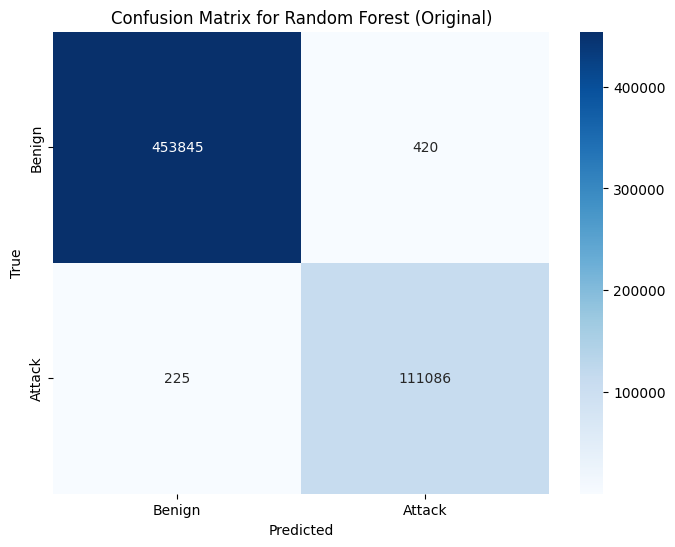

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.999075  Original
1                     PortScan  0.999906  Original
2                         DDoS  0.999180  Original
3                     DoS Hulk  0.999218  Original
4             Web Attack - XSS  0.900000  Original
5                DoS GoldenEye  0.996600  Original
6                  SSH-Patator  0.992373  Original
7             DoS Slowhttptest  0.995455  Original
8                  FTP-Patator  0.998110  Original
9     Web Attack - Brute Force  0.920266  Original
10                         Bot  0.764706  Original
11               DoS slowloris  0.994823  Original
12                Infiltration  0.571429  Original
13  Web Attack - Sql Injection  0.250000  Original
14                  Heartbleed  1.000000  Original


In [28]:
# Predict and evaluate on the test set
rf_metrics["original"] = test_metrics("Random Forest", rf_model, "Original", scaler)

#### With random oversampler

In [29]:
rf_model_random = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.7min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Random Oversampling Test Set Performance


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.4s finished


Classification Report (Test Random Forest (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9997    0.9983    0.9990    454265
           1     0.9932    0.9988    0.9960    111311

    accuracy                         0.9984    565576
   macro avg     0.9964    0.9986    0.9975    565576
weighted avg     0.9984    0.9984    0.9984    565576

Accuracy: 0.9984140062520334
Precision: 0.9984213645293283
Recall: 0.9984140062520334
F1 Score: 0.9984157070999878
AUC: 0.9985684384009011


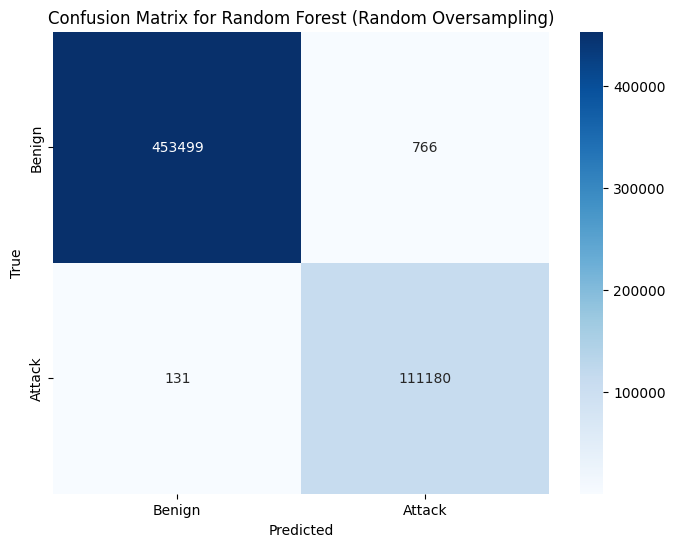

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.998314  Random Oversampling
1                     PortScan  0.999874  Random Oversampling
2                         DDoS  0.999297  Random Oversampling
3                     DoS Hulk  0.999087  Random Oversampling
4             Web Attack - XSS  0.969231  Random Oversampling
5                DoS GoldenEye  0.997086  Random Oversampling
6                  SSH-Patator  0.992373  Random Oversampling
7             DoS Slowhttptest  0.996364  Random Oversampling
8                  FTP-Patator  0.998110  Random Oversampling
9     Web Attack - Brute Force  0.980066  Random Oversampling
10                         Bot  0.938619  Random Oversampling
11               DoS slowloris  0.995686  Random Oversampling
12                Infiltration  0.571429  Random Oversampling
13  Web Attack - Sql Injection  0.250000  Random Oversampling
14                  Heartbleed

In [30]:
# Predict and evaluate on the test set
rf_metrics["random"] = test_metrics("Random Forest", rf_model_random, "Random Oversampling", scaler_random)

#### With SMOTE

In [31]:
rf_model_smote = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.0min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.9s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9997    0.9971    0.9984    454265
           1     0.9882    0.9990    0.9935    111311

    accuracy                         0.9974    565576
   macro avg     0.9940    0.9980    0.9960    565576
weighted avg     0.9975    0.9974    0.9974    565576

Accuracy: 0.9974397782084106
Precision: 0.9974647422347658
Recall: 0.9974397782084106
F1 Score: 0.9974450253315682
AUC: 0.9980162240450211


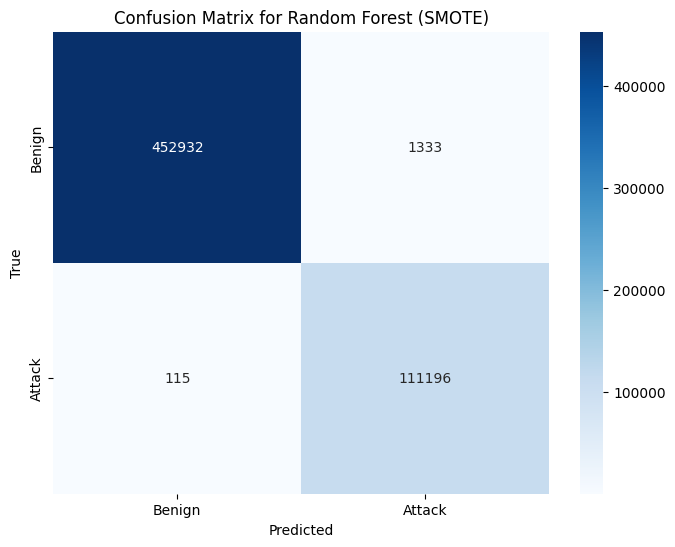

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.997066  SMOTE
1                     PortScan  0.999874  SMOTE
2                         DDoS  0.999219  SMOTE
3                     DoS Hulk  0.999109  SMOTE
4             Web Attack - XSS  0.984615  SMOTE
5                DoS GoldenEye  0.998057  SMOTE
6                  SSH-Patator  0.995763  SMOTE
7             DoS Slowhttptest  0.998182  SMOTE
8                  FTP-Patator  0.998110  SMOTE
9     Web Attack - Brute Force  0.990033  SMOTE
10                         Bot  0.946292  SMOTE
11               DoS slowloris  0.995686  SMOTE
12                Infiltration  0.571429  SMOTE
13  Web Attack - Sql Injection  0.500000  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [32]:
# Predict and evaluate on the test set
rf_metrics["smote"] = test_metrics("Random Forest", rf_model_smote, "SMOTE", scaler_smote)

#### With ADASYN

In [33]:
rf_model_adasyn = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 72.7min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with ADASYN Test Set Performance


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.2s finished


Classification Report (Test Random Forest (ADASYN)):
              precision    recall  f1-score   support

           0     0.9998    0.9971    0.9984    454265
           1     0.9882    0.9991    0.9936    111311

    accuracy                         0.9975    565576
   macro avg     0.9940    0.9981    0.9960    565576
weighted avg     0.9975    0.9975    0.9975    565576

Accuracy: 0.9974645317340198
Precision: 0.9974897820314341
Recall: 0.9974645317340198
F1 Score: 0.997469778925131
AUC: 0.9980757196716297


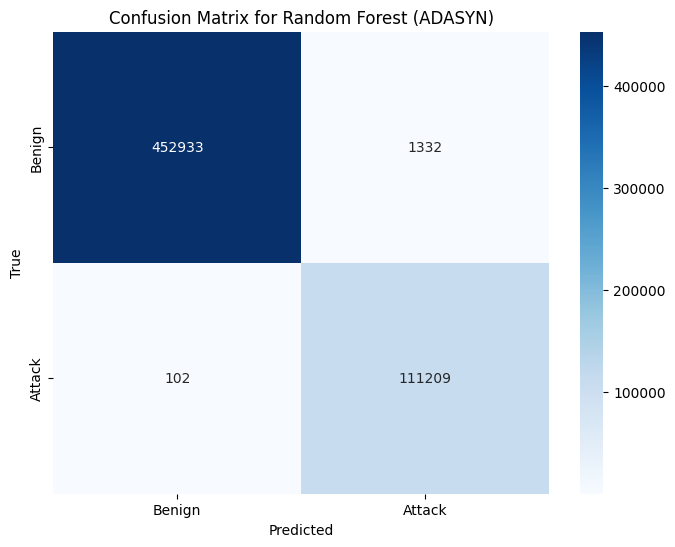

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.997068  ADASYN
1                     PortScan  0.999874  ADASYN
2                         DDoS  0.999336  ADASYN
3                     DoS Hulk  0.999218  ADASYN
4             Web Attack - XSS  0.984615  ADASYN
5                DoS GoldenEye  0.999029  ADASYN
6                  SSH-Patator  0.995763  ADASYN
7             DoS Slowhttptest  0.998182  ADASYN
8                  FTP-Patator  0.999370  ADASYN
9     Web Attack - Brute Force  0.990033  ADASYN
10                         Bot  0.948849  ADASYN
11               DoS slowloris  0.995686  ADASYN
12                Infiltration  0.571429  ADASYN
13  Web Attack - Sql Injection  0.500000  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [34]:
# Predict and evaluate on the test set
rf_metrics["adasyn"] = test_metrics("Random Forest", rf_model_adasyn, "ADASYN", scaler_adasyn)

In [35]:
# Combine metrics into one DataFrame
combined_metrics_rf = pd.concat([rf_metrics["adasyn"][1], rf_metrics["original"][1], rf_metrics["random"][1], rf_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_rf = combined_metrics_rf.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_rf = accuracy_pivot_rf[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_rf)

Accuracy by Label and Method:
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.999075             0.998314  0.997066  0.997068
Bot                         0.764706             0.938619  0.946292  0.948849
DDoS                        0.999180             0.999297  0.999219  0.999336
DoS GoldenEye               0.996600             0.997086  0.998057  0.999029
DoS Hulk                    0.999218             0.999087  0.999109  0.999218
DoS Slowhttptest            0.995455             0.996364  0.998182  0.998182
DoS slowloris               0.994823             0.995686  0.995686  0.995686
FTP-Patator                 0.998110             0.998110  0.998110  0.999370
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.571429             0.571429  0.571429  0.571429
PortScan                    0.9999

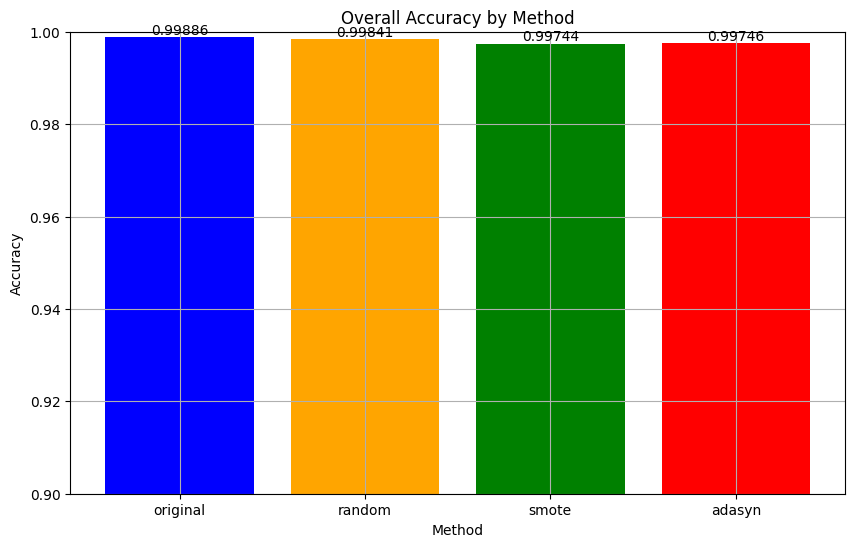

In [36]:
plot_overall_accuracy(rf_metrics)

### Gradient Boost (XGB)

In [37]:
xgb_metrics = {}

In [38]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Original Test Set Performance
Classification Report (Test XGBoost (Original)):
              precision    recall  f1-score   support

           0     0.9995    0.9989    0.9992    454265
           1     0.9957    0.9978    0.9968    111311

    accuracy                         0.9987    565576
   macro avg     0.9976    0.9984    0.9980    565576
weighted avg     0.9987    0.9987    0.9987    565576

Accuracy: 0.9987216572131774
Precision: 0.9987232181776284
Recall: 0.9987216572131774
F1 Score: 0.9987221658410621
AUC: 0.9983767464568043


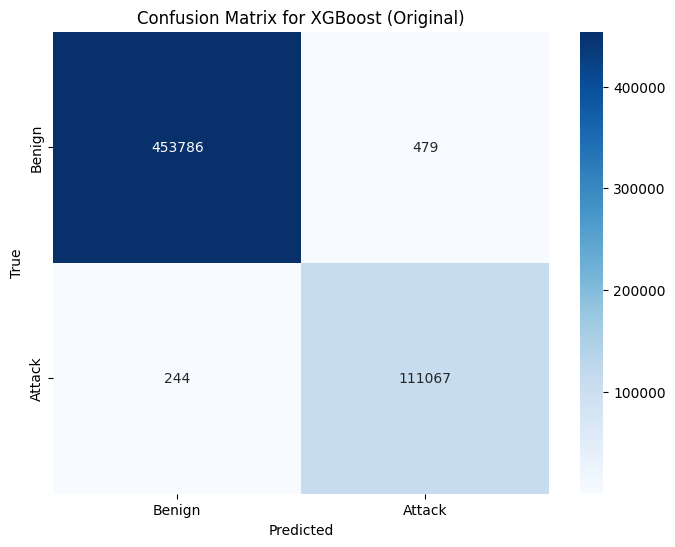

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.998946  Original
1                     PortScan  0.999843  Original
2                         DDoS  0.999180  Original
3                     DoS Hulk  0.999500  Original
4             Web Attack - XSS  0.846154  Original
5                DoS GoldenEye  0.998543  Original
6                  SSH-Patator  0.995763  Original
7             DoS Slowhttptest  0.996364  Original
8                  FTP-Patator  0.998110  Original
9     Web Attack - Brute Force  0.897010  Original
10                         Bot  0.695652  Original
11               DoS slowloris  0.995686  Original
12                Infiltration  0.571429  Original
13  Web Attack - Sql Injection  0.500000  Original
14                  Heartbleed  1.000000  Original


In [39]:
# Predict and evaluate on the test set
# Original Dataset
xgb_metrics["original"] = test_metrics("XGBoost", xgb_model, "Original", scaler)

In [40]:
xgb_model_random = xgb.XGBClassifier(n_jobs=-1)
xgb_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Random Oversampling Test Set Performance
Classification Report (Test XGBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9998    0.9982    0.9990    454265
           1     0.9926    0.9994    0.9960    111311

    accuracy                         0.9984    565576
   macro avg     0.9962    0.9988    0.9975    565576
weighted avg     0.9984    0.9984    0.9984    565576

Accuracy: 0.9984051657071729
Precision: 0.9984149192536511
Recall: 0.9984051657071729
F1 Score: 0.9984072111038548
AUC: 0.9987664094004242


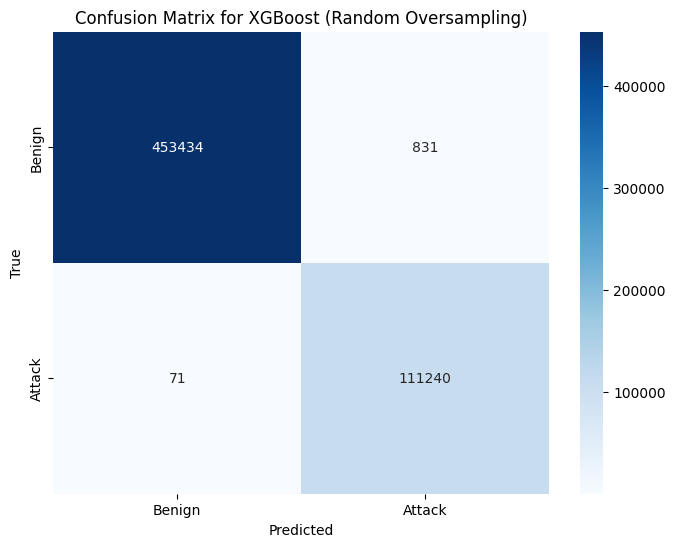

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.998171  Random Oversampling
1                     PortScan  0.999874  Random Oversampling
2                         DDoS  0.999219  Random Oversampling
3                     DoS Hulk  0.999544  Random Oversampling
4             Web Attack - XSS  0.984615  Random Oversampling
5                DoS GoldenEye  0.999029  Random Oversampling
6                  SSH-Patator  0.998305  Random Oversampling
7             DoS Slowhttptest  0.999091  Random Oversampling
8                  FTP-Patator  0.998110  Random Oversampling
9     Web Attack - Brute Force  0.983389  Random Oversampling
10                         Bot  0.992327  Random Oversampling
11               DoS slowloris  0.996549  Random Oversampling
12                Infiltration  0.571429  Random Oversampling
13  Web Attack - Sql Injection  0.750000  Random Oversampling
14                  Heartbleed

In [41]:
# Predict and evaluate on the test set
# Random Oversampling
xgb_metrics["random"] = test_metrics("XGBoost", xgb_model_random, "Random Oversampling", scaler_random)

In [42]:
xgb_model_smote = xgb.XGBClassifier(n_jobs=-1)
xgb_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9998    0.9976    0.9987    454265
           1     0.9905    0.9993    0.9949    111311

    accuracy                         0.9980    565576
   macro avg     0.9951    0.9985    0.9968    565576
weighted avg     0.9980    0.9980    0.9980    565576

Accuracy: 0.9979702109000382
Precision: 0.9979866727968727
Recall: 0.9979702109000382
F1 Score: 0.9979736106413502
AUC: 0.9984752948976342


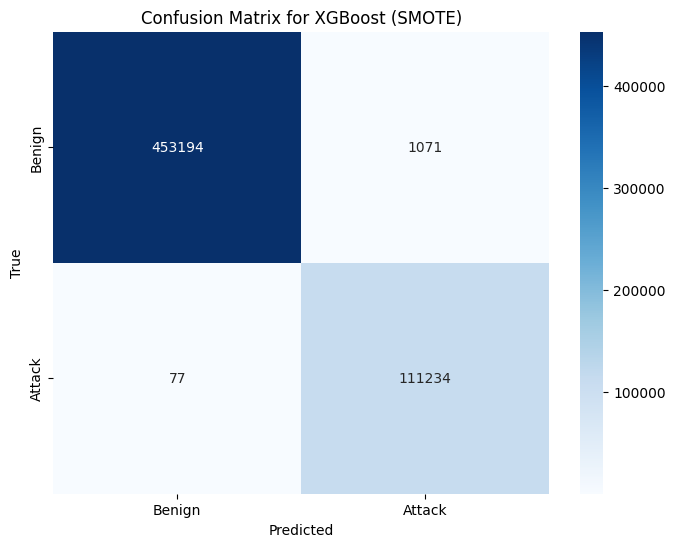

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.997642  SMOTE
1                     PortScan  0.999906  SMOTE
2                         DDoS  0.998867  SMOTE
3                     DoS Hulk  0.999544  SMOTE
4             Web Attack - XSS  0.992308  SMOTE
5                DoS GoldenEye  0.999029  SMOTE
6                  SSH-Patator  0.998305  SMOTE
7             DoS Slowhttptest  0.998182  SMOTE
8                  FTP-Patator  0.998740  SMOTE
9     Web Attack - Brute Force  0.980066  SMOTE
10                         Bot  0.997442  SMOTE
11               DoS slowloris  0.996549  SMOTE
12                Infiltration  0.571429  SMOTE
13  Web Attack - Sql Injection  0.750000  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [43]:
# Predict and evaluate on the test set
# SMOTE
xgb_metrics["smote"] = test_metrics("XGBoost", xgb_model_smote, "SMOTE", scaler_smote)

In [44]:
xgb_model_adasyn = xgb.XGBClassifier(n_jobs=-1)
xgb_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with ADASYN Test Set Performance
Classification Report (Test XGBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9998    0.9969    0.9983    454265
           1     0.9874    0.9991    0.9932    111311

    accuracy                         0.9973    565576
   macro avg     0.9936    0.9980    0.9958    565576
weighted avg     0.9973    0.9973    0.9973    565576

Accuracy: 0.9973107062534479
Precision: 0.9973398660929645
Recall: 0.9973107062534479
F1 Score: 0.997316707034026
AUC: 0.9979969167878685


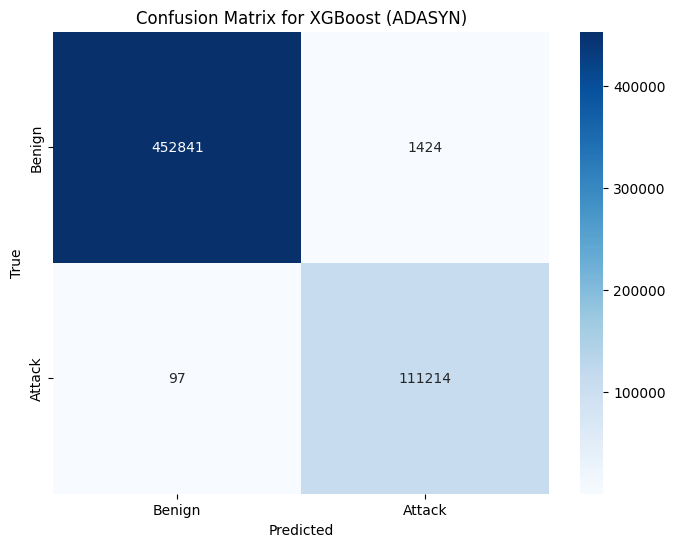

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.996865  ADASYN
1                     PortScan  0.999843  ADASYN
2                         DDoS  0.998867  ADASYN
3                     DoS Hulk  0.998979  ADASYN
4             Web Attack - XSS  0.992308  ADASYN
5                DoS GoldenEye  0.999514  ADASYN
6                  SSH-Patator  0.999153  ADASYN
7             DoS Slowhttptest  0.998182  ADASYN
8                  FTP-Patator  1.000000  ADASYN
9     Web Attack - Brute Force  0.983389  ADASYN
10                         Bot  0.994885  ADASYN
11               DoS slowloris  0.998274  ADASYN
12                Infiltration  0.714286  ADASYN
13  Web Attack - Sql Injection  1.000000  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [45]:
# Predict and evaluate on the test set
# ADASYN
xgb_metrics["adasyn"] = test_metrics("XGBoost", xgb_model_adasyn, "ADASYN", scaler_adasyn)

In [46]:
# Combine metrics into one DataFrame
combined_metrics_xgb = pd.concat([xgb_metrics["adasyn"][1], xgb_metrics["original"][1], xgb_metrics["random"][1], xgb_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_xgb = combined_metrics_xgb.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_xgb = accuracy_pivot_xgb[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_xgb)

Accuracy by Label and Method:
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.998946             0.998171  0.997642  0.996865
Bot                         0.695652             0.992327  0.997442  0.994885
DDoS                        0.999180             0.999219  0.998867  0.998867
DoS GoldenEye               0.998543             0.999029  0.999029  0.999514
DoS Hulk                    0.999500             0.999544  0.999544  0.998979
DoS Slowhttptest            0.996364             0.999091  0.998182  0.998182
DoS slowloris               0.995686             0.996549  0.996549  0.998274
FTP-Patator                 0.998110             0.998110  0.998740  1.000000
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.571429             0.571429  0.571429  0.714286
PortScan                    0.9998

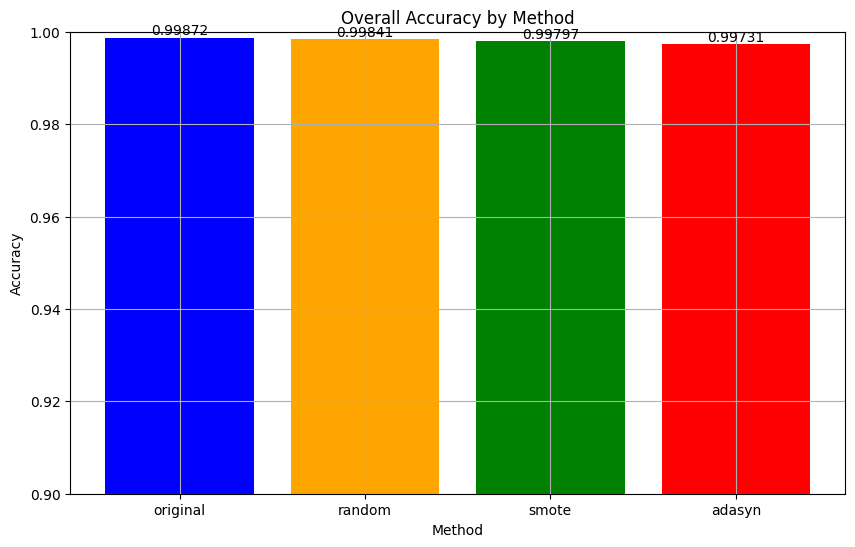

In [47]:
plot_overall_accuracy(xgb_metrics)

### AdaBoost

In [48]:
ada_metrics = {}

In [49]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME')
ada_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Original Test Set Performance
Classification Report (Test AdaBoost (Original)):
              precision    recall  f1-score   support

           0     0.9850    0.9880    0.9865    454265
           1     0.9503    0.9386    0.9444    111311

    accuracy                         0.9783    565576
   macro avg     0.9676    0.9633    0.9654    565576
weighted avg     0.9782    0.9783    0.9782    565576

Accuracy: 0.9782522596432663
Precision: 0.9781681874949125
Recall: 0.9782522596432663
F1 Score: 0.9782013006157849
AUC: 0.9632825219922287


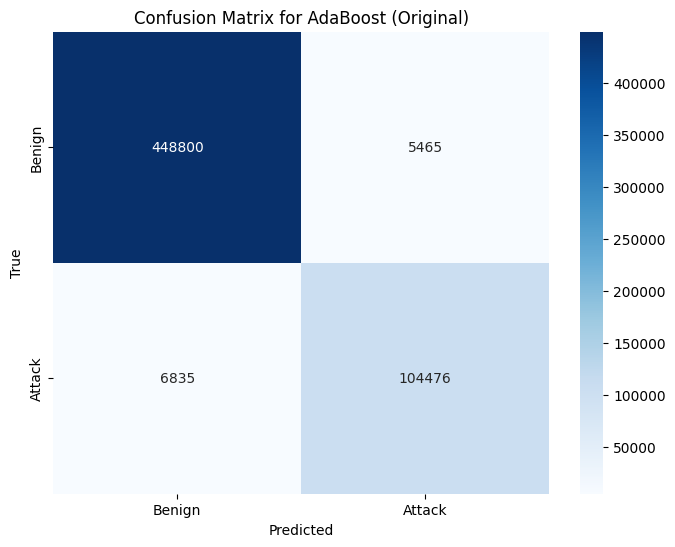

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.987970  Original
1                     PortScan  0.992979  Original
2                         DDoS  0.971607  Original
3                     DoS Hulk  0.958110  Original
4             Web Attack - XSS  0.007692  Original
5                DoS GoldenEye  0.472074  Original
6                  SSH-Patator  0.483051  Original
7             DoS Slowhttptest  0.567273  Original
8                  FTP-Patator  0.712665  Original
9     Web Attack - Brute Force  0.046512  Original
10                         Bot  0.010230  Original
11               DoS slowloris  0.557377  Original
12                Infiltration  0.000000  Original
13  Web Attack - Sql Injection  0.250000  Original
14                  Heartbleed  0.000000  Original


In [50]:
# Predict and evaluate on the test set
ada_metrics["original"] = test_metrics("AdaBoost", ada_model, "Original", scaler)

In [51]:
ada_model_random = AdaBoostClassifier(algorithm='SAMME')
ada_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Random Oversampling Test Set Performance
Classification Report (Test AdaBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9884    0.9206    0.9533    454265
           1     0.7469    0.9559    0.8386    111311

    accuracy                         0.9276    565576
   macro avg     0.8676    0.9383    0.8959    565576
weighted avg     0.9409    0.9276    0.9307    565576

Accuracy: 0.9275658797403001
Precision: 0.9408703866366304
Recall: 0.9275658797403001
F1 Score: 0.9307260330255909
AUC: 0.9382710554904313


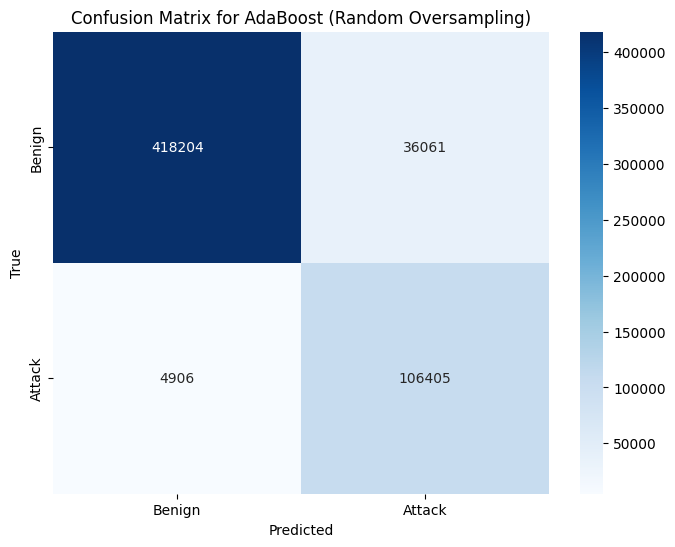

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.920617  Random Oversampling
1                     PortScan  0.996914  Random Oversampling
2                         DDoS  0.911228  Random Oversampling
3                     DoS Hulk  0.953004  Random Oversampling
4             Web Attack - XSS  1.000000  Random Oversampling
5                DoS GoldenEye  0.990287  Random Oversampling
6                  SSH-Patator  0.973729  Random Oversampling
7             DoS Slowhttptest  0.980909  Random Oversampling
8                  FTP-Patator  0.865784  Random Oversampling
9     Web Attack - Brute Force  0.953488  Random Oversampling
10                         Bot  0.854220  Random Oversampling
11               DoS slowloris  0.987921  Random Oversampling
12                Infiltration  0.714286  Random Oversampling
13  Web Attack - Sql Injection  1.000000  Random Oversampling
14                  Heartbleed

In [52]:
# Predict and evaluate on the test set
ada_metrics["random"] = test_metrics("AdaBoost", ada_model_random, "Random Oversampling", scaler_random)

In [53]:
ada_model_smote = AdaBoostClassifier(algorithm='SAMME')
ada_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with SMOTE Test Set Performance
Classification Report (Test AdaBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9906    0.9151    0.9513    454265
           1     0.7356    0.9644    0.8346    111311

    accuracy                         0.9248    565576
   macro avg     0.8631    0.9397    0.8929    565576
weighted avg     0.9404    0.9248    0.9283    565576

Accuracy: 0.9247634270195341
Precision: 0.9403738580073305
Recall: 0.9247634270195341
F1 Score: 0.9283363903711626
AUC: 0.939724418330063


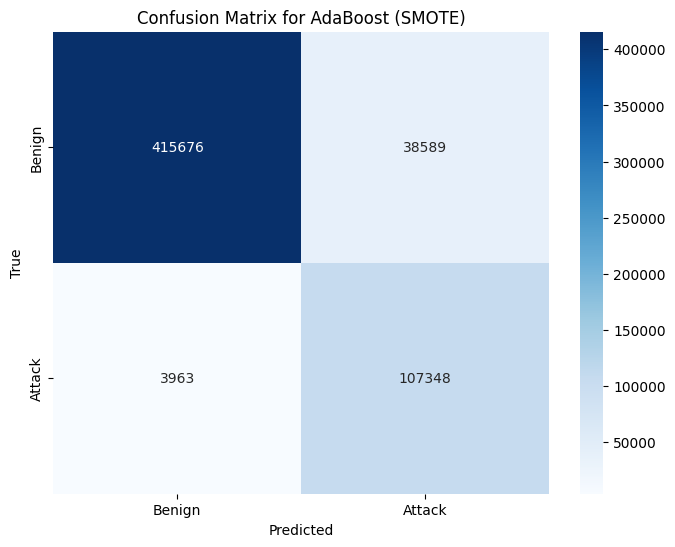

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.915052  SMOTE
1                     PortScan  0.996914  SMOTE
2                         DDoS  0.970435  SMOTE
3                     DoS Hulk  0.952873  SMOTE
4             Web Attack - XSS  0.976923  SMOTE
5                DoS GoldenEye  0.990287  SMOTE
6                  SSH-Patator  0.974576  SMOTE
7             DoS Slowhttptest  0.988182  SMOTE
8                  FTP-Patator  0.492124  SMOTE
9     Web Attack - Brute Force  0.953488  SMOTE
10                         Bot  0.879795  SMOTE
11               DoS slowloris  0.996549  SMOTE
12                Infiltration  0.714286  SMOTE
13  Web Attack - Sql Injection  1.000000  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [54]:
# Predict and evaluate on the test set
ada_metrics["smote"] = test_metrics("AdaBoost", ada_model_smote, "SMOTE", scaler_smote)

In [55]:
ada_model_adasyn = AdaBoostClassifier(algorithm='SAMME')
ada_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with ADASYN Test Set Performance
Classification Report (Test AdaBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9958    0.8875    0.9385    454265
           1     0.6819    0.9846    0.8057    111311

    accuracy                         0.9066    565576
   macro avg     0.8388    0.9360    0.8721    565576
weighted avg     0.9340    0.9066    0.9124    565576

Accuracy: 0.9065695856967056
Precision: 0.9339865423783671
Recall: 0.9065695856967056
F1 Score: 0.9123675780008642
AUC: 0.936011763812719


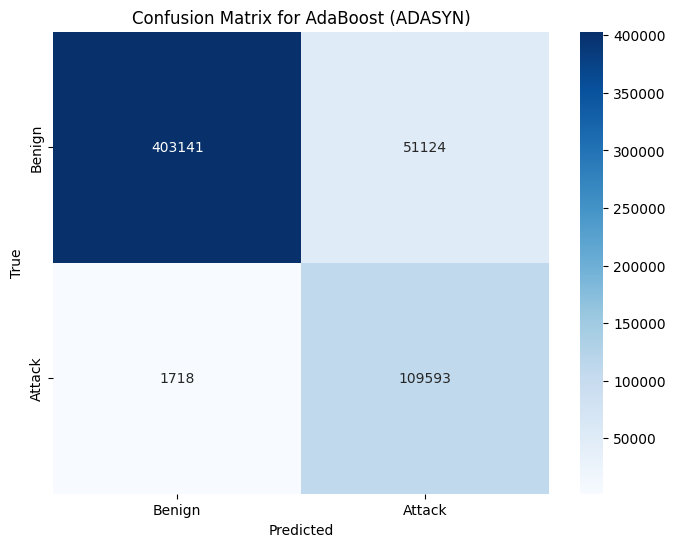

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.887458  ADASYN
1                     PortScan  0.996914  ADASYN
2                         DDoS  0.970475  ADASYN
3                     DoS Hulk  0.985204  ADASYN
4             Web Attack - XSS  0.976923  ADASYN
5                DoS GoldenEye  1.000000  ADASYN
6                  SSH-Patator  0.980508  ADASYN
7             DoS Slowhttptest  0.996364  ADASYN
8                  FTP-Patator  0.997480  ADASYN
9     Web Attack - Brute Force  1.000000  ADASYN
10                         Bot  0.631714  ADASYN
11               DoS slowloris  0.997412  ADASYN
12                Infiltration  0.714286  ADASYN
13  Web Attack - Sql Injection  1.000000  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [56]:
# Predict and evaluate on the test set
ada_metrics["adasyn"] = test_metrics("AdaBoost", ada_model_adasyn, "ADASYN", scaler_adasyn)

In [57]:
# Combine metrics into one DataFrame
combined_metrics_ada = pd.concat([ada_metrics["adasyn"][1], ada_metrics["original"][1], ada_metrics["random"][1], ada_metrics["smote"][1]])

# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_ada = combined_metrics_ada.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_ada = accuracy_pivot_ada[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (AdaBoost):")
print(accuracy_pivot_ada)

Accuracy by Label and Method (AdaBoost):
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.987970             0.920617  0.915052  0.887458
Bot                         0.010230             0.854220  0.879795  0.631714
DDoS                        0.971607             0.911228  0.970435  0.970475
DoS GoldenEye               0.472074             0.990287  0.990287  1.000000
DoS Hulk                    0.958110             0.953004  0.952873  0.985204
DoS Slowhttptest            0.567273             0.980909  0.988182  0.996364
DoS slowloris               0.557377             0.987921  0.996549  0.997412
FTP-Patator                 0.712665             0.865784  0.492124  0.997480
Heartbleed                  0.000000             1.000000  1.000000  1.000000
Infiltration                0.000000             0.714286  0.714286  0.714286
PortScan               

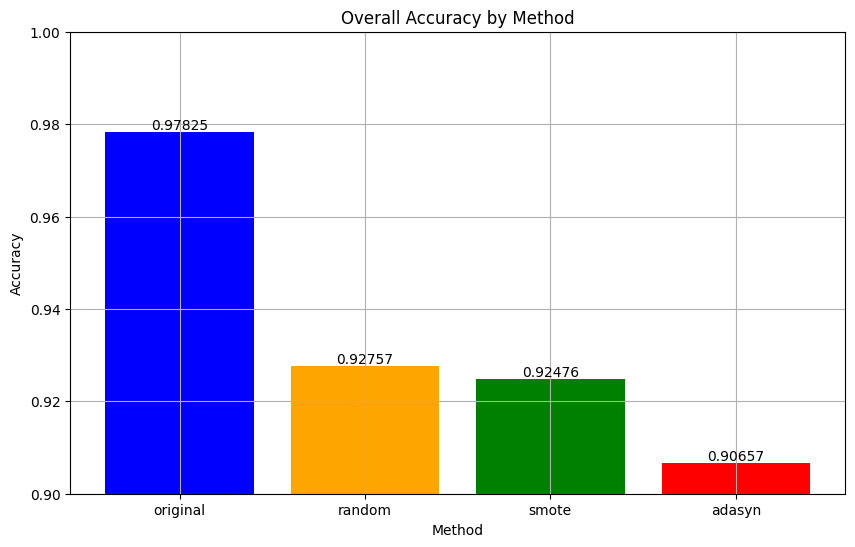

In [58]:
plot_overall_accuracy(ada_metrics)

### Decision Tree

In [59]:
dt_metrics = {}

In [60]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Original Test Set Performance
Classification Report (Test Decision Tree (Original)):
              precision    recall  f1-score   support

           0     0.9995    0.9990    0.9992    454265
           1     0.9958    0.9979    0.9968    111311

    accuracy                         0.9988    565576
   macro avg     0.9977    0.9984    0.9980    565576
weighted avg     0.9988    0.9988    0.9988    565576

Accuracy: 0.9987570193926192
Precision: 0.9987584649701461
Recall: 0.9987570193926192
F1 Score: 0.9987574929354088
AUC: 0.9984157162387777


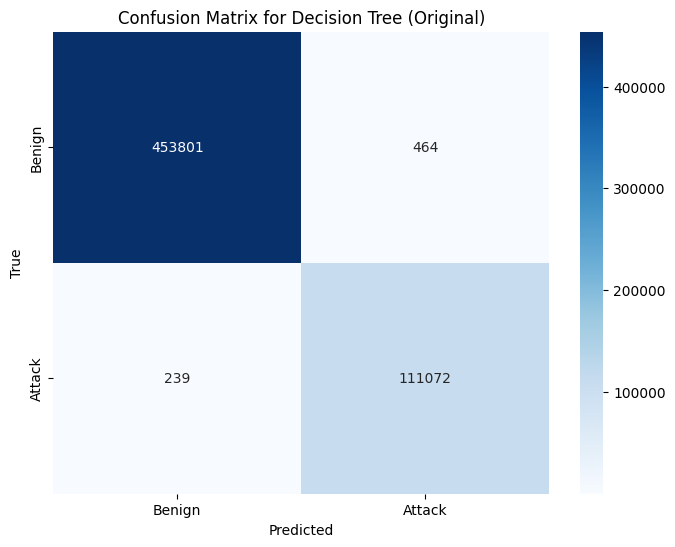

Metrics by Label (Original):
                         Label  Accuracy    Method
0                       BENIGN  0.998979  Original
1                     PortScan  0.999843  Original
2                         DDoS  0.999531  Original
3                     DoS Hulk  0.999109  Original
4             Web Attack - XSS  0.876923  Original
5                DoS GoldenEye  0.997086  Original
6                  SSH-Patator  0.994068  Original
7             DoS Slowhttptest  0.965455  Original
8                  FTP-Patator  0.998740  Original
9     Web Attack - Brute Force  0.910299  Original
10                         Bot  0.808184  Original
11               DoS slowloris  0.995686  Original
12                Infiltration  0.571429  Original
13  Web Attack - Sql Injection  0.500000  Original
14                  Heartbleed  1.000000  Original


In [61]:
# Predict and evaluate on the test set
dt_metrics["original"] = test_metrics("Decision Tree", decision_tree_model, "Original", scaler)

In [62]:
decision_tree_model_random = DecisionTreeClassifier()
decision_tree_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Random Oversampling Test Set Performance
Classification Report (Test Decision Tree (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9994    0.9990    0.9992    454265
           1     0.9958    0.9977    0.9967    111311

    accuracy                         0.9987    565576
   macro avg     0.9976    0.9983    0.9980    565576
weighted avg     0.9987    0.9987    0.9987    565576

Accuracy: 0.9987057442324285
Precision: 0.9987070989679732
Recall: 0.9987057442324285
F1 Score: 0.9987062044814029
AUC: 0.9983091892661162


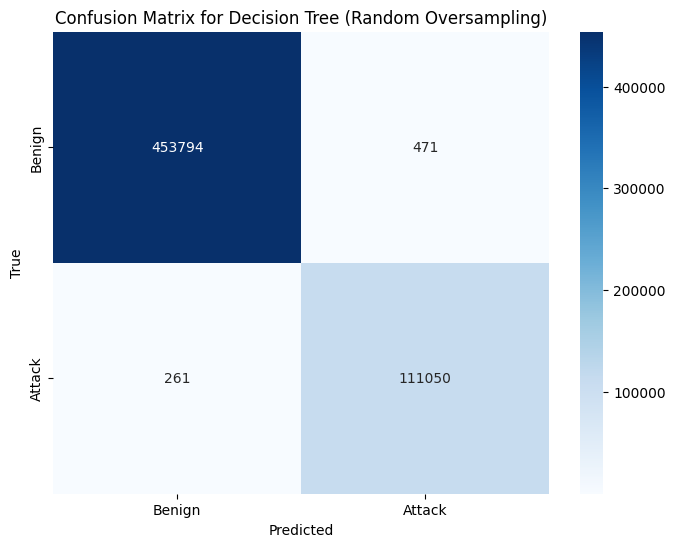

Metrics by Label (Random Oversampling):
                         Label  Accuracy               Method
0                       BENIGN  0.998963  Random Oversampling
1                     PortScan  0.999937  Random Oversampling
2                         DDoS  0.999414  Random Oversampling
3                     DoS Hulk  0.999087  Random Oversampling
4             Web Attack - XSS  0.853846  Random Oversampling
5                DoS GoldenEye  0.994172  Random Oversampling
6                  SSH-Patator  0.994068  Random Oversampling
7             DoS Slowhttptest  0.965455  Random Oversampling
8                  FTP-Patator  0.996849  Random Oversampling
9     Web Attack - Brute Force  0.880399  Random Oversampling
10                         Bot  0.818414  Random Oversampling
11               DoS slowloris  0.992235  Random Oversampling
12                Infiltration  0.428571  Random Oversampling
13  Web Attack - Sql Injection  0.750000  Random Oversampling
14                  Heartbleed

In [63]:
# Predict and evaluate on the test set
dt_metrics["random"] = test_metrics("Decision Tree", decision_tree_model_random, "Random Oversampling", scaler_random)

In [64]:
decision_tree_model_smote = DecisionTreeClassifier()
decision_tree_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

DecisionTreeClassifier()

Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9997    0.9987    0.9992    454265
           1     0.9947    0.9987    0.9967    111311

    accuracy                         0.9987    565576
   macro avg     0.9972    0.9987    0.9979    565576
weighted avg     0.9987    0.9987    0.9987    565576

Accuracy: 0.9986915993606518
Precision: 0.9986954495792087
Recall: 0.9986915993606518
F1 Score: 0.99869257281876
AUC: 0.9986768114641326


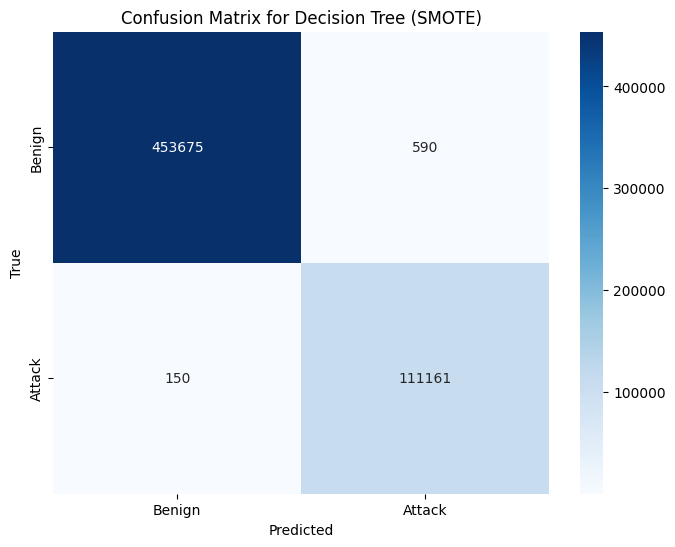

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.998701  SMOTE
1                     PortScan  0.999874  SMOTE
2                         DDoS  0.999531  SMOTE
3                     DoS Hulk  0.999283  SMOTE
4             Web Attack - XSS  0.969231  SMOTE
5                DoS GoldenEye  0.995629  SMOTE
6                  SSH-Patator  0.995763  SMOTE
7             DoS Slowhttptest  0.980909  SMOTE
8                  FTP-Patator  0.998740  SMOTE
9     Web Attack - Brute Force  0.980066  SMOTE
10                         Bot  0.890026  SMOTE
11               DoS slowloris  0.997412  SMOTE
12                Infiltration  0.428571  SMOTE
13  Web Attack - Sql Injection  0.000000  SMOTE
14                  Heartbleed  1.000000  SMOTE


In [65]:
# Predict and evaluate on the test set
dt_metrics["smote"] = test_metrics("Decision Tree", decision_tree_model_smote, "SMOTE", scaler_smote)

In [66]:
decision_tree_model_adasyn = DecisionTreeClassifier()
decision_tree_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

DecisionTreeClassifier()

Decision Tree with ADASYN Test Set Performance
Classification Report (Test Decision Tree (ADASYN)):
              precision    recall  f1-score   support

           0     0.9997    0.9986    0.9991    454265
           1     0.9944    0.9986    0.9965    111311

    accuracy                         0.9986    565576
   macro avg     0.9970    0.9986    0.9978    565576
weighted avg     0.9986    0.9986    0.9986    565576

Accuracy: 0.998619106892796
Precision: 0.9986235979715091
Recall: 0.998619106892796
F1 Score: 0.9986202250752974
AUC: 0.9986282923803343


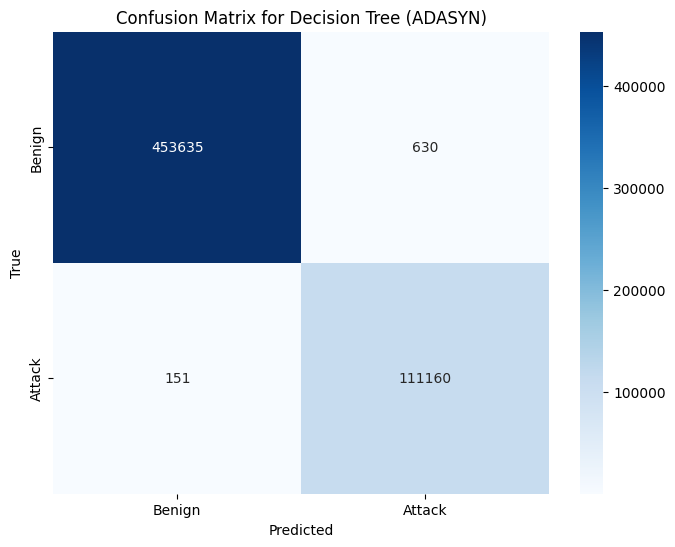

Metrics by Label (ADASYN):
                         Label  Accuracy  Method
0                       BENIGN  0.998613  ADASYN
1                     PortScan  0.999874  ADASYN
2                         DDoS  0.999414  ADASYN
3                     DoS Hulk  0.999283  ADASYN
4             Web Attack - XSS  0.976923  ADASYN
5                DoS GoldenEye  0.999029  ADASYN
6                  SSH-Patator  0.994915  ADASYN
7             DoS Slowhttptest  0.980000  ADASYN
8                  FTP-Patator  0.998110  ADASYN
9     Web Attack - Brute Force  0.970100  ADASYN
10                         Bot  0.884910  ADASYN
11               DoS slowloris  0.995686  ADASYN
12                Infiltration  0.571429  ADASYN
13  Web Attack - Sql Injection  0.750000  ADASYN
14                  Heartbleed  1.000000  ADASYN


In [67]:
# Predict and evaluate on the test set
dt_metrics["adasyn"] = test_metrics("Decision Tree", decision_tree_model_adasyn, "ADASYN", scaler_adasyn)

In [68]:
# Combine metrics into one DataFrame for Decision Tree
combined_metrics_dt = pd.concat([dt_metrics["adasyn"][1], dt_metrics["original"][1], dt_metrics["random"][1], dt_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_dt = combined_metrics_dt.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_dt = accuracy_pivot_dt[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (Decision Tree):")
print(accuracy_pivot_dt)

Accuracy by Label and Method (Decision Tree):
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.998979             0.998963  0.998701  0.998613
Bot                         0.808184             0.818414  0.890026  0.884910
DDoS                        0.999531             0.999414  0.999531  0.999414
DoS GoldenEye               0.997086             0.994172  0.995629  0.999029
DoS Hulk                    0.999109             0.999087  0.999283  0.999283
DoS Slowhttptest            0.965455             0.965455  0.980909  0.980000
DoS slowloris               0.995686             0.992235  0.997412  0.995686
FTP-Patator                 0.998740             0.996849  0.998740  0.998110
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.571429             0.428571  0.428571  0.571429
PortScan          

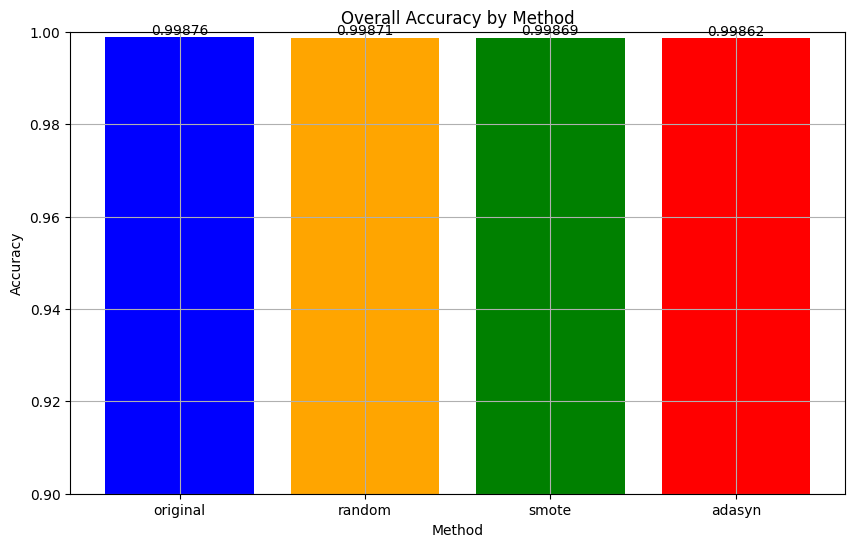

In [69]:
plot_overall_accuracy(dt_metrics)